##  <font color = "navy">WEATHER FORECAST IN AUSTRALIA: Modélisation machine learning</font>
Notebook <b>2/3</b>
***

<font color = "purple"><b>Objectif: Réaliser un modèle de machine learning capable de détecter les jours de pluie à J+1 avec une précision satisfaisante.</b></font>

<b> Résumé du notebook : </b>
- Data cleaning, preprocessing des données (notamment encodage, et rééquilibrage) ;
- Modélisation Random Forest ;
- Analyse des résultats et perspectives d'améliorations du modèle ;
- Essai d'amélioration des performances du modèle.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling  import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
import warnings
from scipy import stats
from IPython.display import Markdown, display
warnings.filterwarnings('ignore')
sns.set_theme({'legend.frameon':True})

In [2]:
df = pd.read_csv("weatherAUS.csv")

#Création d'un df de secours pour avoir une trace des données brutes.

df_saved = pd.read_csv("weatherAUS.csv")

pd.set_option("display.max_columns", None)

In [3]:
display(Markdown("<h2><u><center>Préprocessing des données</center></u></h2>"))
display(Markdown("<h4><u>Traitement des données manquantes :</u></h4>"))
display(Markdown("<h5><i>Suppressions :</i></h5>"))

df = df.drop(['Rainfall', 'WindGustSpeed', 'Cloud9am', 'Cloud3pm', 'Pressure9am', 'Pressure3pm','Evaporation', 'Sunshine'], axis = 1)
df.dropna(axis = 0, how = 'any', subset = ['RainToday', 'RainTomorrow'], inplace = True)
df['year'] = pd.to_datetime(df.Date).dt.year
df['month'] = pd.to_datetime(df.Date).dt.month
df['day'] = pd.to_datetime(df.Date).dt.day

df.drop('Date', axis = 1, inplace = True)


display(Markdown("""Les variables comportant une importante quantité de valeurs manquantes sont supprimées :
<i>Rainfall</i>, <i>WindGustSpeed</i>, <i>Cloud9am</i>, <i>Cloud3pm</i>, <i>Pressure9am</i>, 
<i>Pressure3pm</i>, <i>Evaporation</i> et <i>Sunshine</i>. Concernant les variables <i>RainToday</i> et <i>RainTomorrow</i>,
les entrées avec une valeur manquante pour l'une de ces variables sont supprimées.
"""))

display(Markdown("<h5><i>Remplacement :</i></h5>"))
display(Markdown("""Pour garder une cohérence dans les valeurs de remplacement, les manquants seront remplacés, 
pour chaque variable, par la moyenne sur le mois en fonction de l'année et de la sation considérée. Création de variables
temporaires : <i>year</i>, <i>month</i> et <i>day</i>, afin de procéder à un tel remplacement. Les variables <i>WindSpeed9am</i>
et <i>WindSpeed3pm</i> ne seront pas concernées par ce remplacement, en raison de l'importante variabilité existante d'un jour
à l'autre.
"""))

mean_per_location = df.groupby(['Location','month', 'year']).mean().reset_index()

for row in df.itertuples():
    # Si l'attribut MinTemp de la ligne row est nul: on va remplacer dans df, à l'index row, la valeur de MinTemp, par la moyenne calculée dans mean_per_location, pour la station/mois/année correspondante.
    if pd.isna(row.MinTemp):
        df.loc[row.Index, 'MinTemp'] = mean_per_location[(mean_per_location['Location'] == row.Location) & (mean_per_location['month'] == row.month) & (mean_per_location['year'] == row.year)]['MinTemp'].values[0]
    
    # On applique le même raisonnement pour MaxTemp et autres...
    if pd.isna(row.MaxTemp):
        df.loc[row.Index, 'MaxTemp'] = mean_per_location[(mean_per_location['Location'] == row.Location) & (mean_per_location['month'] == row.month) & (mean_per_location['year'] == row.year)]['MaxTemp'].values[0]
    
    if pd.isna(row.Temp9am):
        df.loc[row.Index, 'Temp9am'] = mean_per_location[(mean_per_location['Location'] == row.Location) & (mean_per_location['month'] == row.month) & (mean_per_location['year'] == row.year)]['Temp9am'].values[0]
    
    if pd.isna(row.Temp9am):
        df.loc[row.Index, 'Temp3pm'] = mean_per_location[(mean_per_location['Location'] == row.Location) & (mean_per_location['month'] == row.month) & (mean_per_location['year'] == row.year)]['Temp3pm'].values[0]
    
    if pd.isna(row.Humidity9am):
        df.loc[row.Index, 'Humidity9am'] = mean_per_location[(mean_per_location['Location'] == row.Location) & (mean_per_location['month'] == row.month) & (mean_per_location['year'] == row.year)]['Humidity9am'].values[0]
    
    if pd.isna(row.Humidity3pm):
        df.loc[row.Index, 'Humidity3pm'] = mean_per_location[(mean_per_location['Location'] == row.Location) & (mean_per_location['month'] == row.month) & (mean_per_location['year'] == row.year)]['Humidity3pm'].values[0]

display(Markdown("<i>Affichage des valeurs manquantes restantes après remplacement :"))
print(df.isna().sum())
display(Markdown("""<br>Malgré le traitement, il reste encore des valeurs manquantes pour <i>Humidity</i> et <i>Temp3pm</i>.
Il existe en effet des stations pour lesquelles les relevés sont manquants pour le mois complet : les valeurs manquantes restantes
seront toutes supprimées.
"""))

df.dropna(axis = 0, subset = ['Humidity9am', 'Humidity3pm', 'Temp3pm', 'WindSpeed9am', 'WindSpeed3pm','WindGustDir', 'WindDir9am', 'WindDir3pm'], inplace = True)

display(Markdown("<h5><i>Bilan du traitement :</i></h5>"))
# Stations supprimées: 
Loc = ['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree','Newcastle', 'NorahHead', 'NorfolkIsland', 
       'Penrith', 'Richmond', 'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown', 'Wollongong', 'Canberra', 
       'Tuggeranong', 'MountGinini', 'Ballarat', 'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura', 
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns', 'GoldCoast', 'Townsville', 'Adelaide', 
       'MountGambier', 'Nuriootpa', 'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport', 'Perth', 
       'SalmonGums', 'Walpole', 'Hobart', 'Launceston', 'AliceSprings', 'Darwin', 'Katherine', 'Uluru']

stat_erased = []

for loc in Loc:
    if loc not in df.Location.unique():
        stat_erased.append(loc)

df.drop(['Location', 'year', 'month', 'day'], axis = 1, inplace = True)

display(Markdown("""Après traitement des données manquantes, la base de données comporte <b>{}</b> entrées (<b>{} %</b> des 
entrées initiales). Sur les 49 stations, les données de <b>{}</b> d'entre elles ont été complètement supprimées. Enfin,
les variables <i>Location</i>, <i>year</i>, <i>month</i> et <i>day</i> n'auront pas d'utilité pour la modélisation et 
sont donc supprimées de la base.
""".format(len(df),
           round(100*len(df)/len(df_saved), 1),
           len(stat_erased))))

display(Markdown("<h4><u>Préparation des données</u></h4>"))
display(Markdown("<h5><i>Encodage des variables qualitatives</i></h5>"))
display(Markdown("""Pour <i>RainToday</i> et <i>RainTomorrow</i>, la valeur "<i>Yes</i>" est remplacée par l'entier 1 et la
valeur "<i>No</i>" est remplacée par l'entier 0. Concernant les variables relatives à la direction du vent (<i>WindGustDir</i>,
<i>WindDir9am</i> et <i>WindDir3pm</i>), celles-ci ont chacune 16 modalités, l'utilisation d'une méthode <i>.get_dummies</i>
entraînerait la création de 48 variables. L'encodage sera fait avec la méthode <i>.LabelEncoder</i> qui ne semble pas biaiser
le poids des modalités lorsque comparé à <i>.get_dummies</i>.
"""))

# RainToday et RainTomorrow:
df.replace(['Yes', 'No'], [1, 0], inplace = True)

#WindGustDir, WindDir9am et WindDir 3pm:
wind = df['WindGustDir'].unique()
label = preprocessing.LabelEncoder() 
labels = label.fit_transform(wind)
df.replace(wind, labels, inplace = True)

display(Markdown("<h5><i>Création des ensembles train et test :</i></h5>"))
display(Markdown("""Le dataframe est séparé en deux dataframes nommés "data" et "target", le premier contenant
toutes les variables sauf <i>RainTomorrow</i> et le second uniquement <i>RainTomorrow</i>, la variable à prédire. Le ratio
est fixé à 0.2 pour les ensembles d'apprentissage et de test. Les données sont ensuite rééquilibrées à l'aide d'un
oversampling (fraction 60/40) puis d'un undersampling.
"""))

data, target = df.drop('RainTomorrow', axis = 1), df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2)
over = RandomOverSampler(sampling_strategy = 0.6) # Fraction 60/40 
under = RandomUnderSampler() 
X_ov, y_ov = over.fit_resample(X_train, y_train) 
X_res, y_res = under.fit_resample(X_ov, y_ov) 



<h2><u><center>Préprocessing des données</center></u></h2>

<h4><u>Traitement des données manquantes :</u></h4>

<h5><i>Suppressions :</i></h5>

Les variables comportant une importante quantité de valeurs manquantes sont supprimées :
<i>Rainfall</i>, <i>WindGustSpeed</i>, <i>Cloud9am</i>, <i>Cloud3pm</i>, <i>Pressure9am</i>, 
<i>Pressure3pm</i>, <i>Evaporation</i> et <i>Sunshine</i>. Concernant les variables <i>RainToday</i> et <i>RainTomorrow</i>,
les entrées avec une valeur manquante pour l'une de ces variables sont supprimées.


<h5><i>Remplacement :</i></h5>

Pour garder une cohérence dans les valeurs de remplacement, les manquants seront remplacés, 
pour chaque variable, par la moyenne sur le mois en fonction de l'année et de la sation considérée. Création de variables
temporaires : <i>year</i>, <i>month</i> et <i>day</i>, afin de procéder à un tel remplacement. Les variables <i>WindSpeed9am</i>
et <i>WindSpeed3pm</i> ne seront pas concernées par ce remplacement, en raison de l'importante variabilité existante d'un jour
à l'autre.


<i>Affichage des valeurs manquantes restantes après remplacement :

Location           0
MinTemp            0
MaxTemp            0
WindGustDir     9163
WindDir9am      9660
WindDir3pm      3670
WindSpeed9am    1055
WindSpeed3pm    2531
Humidity9am      418
Humidity3pm     2386
Temp9am            0
Temp3pm         2427
RainToday          0
RainTomorrow       0
year               0
month              0
day                0
dtype: int64


<br>Malgré le traitement, il reste encore des valeurs manquantes pour <i>Humidity</i> et <i>Temp3pm</i>.
Il existe en effet des stations pour lesquelles les relevés sont manquants pour le mois complet : les valeurs manquantes restantes
seront toutes supprimées.


<h5><i>Bilan du traitement :</i></h5>

Après traitement des données manquantes, la base de données comporte <b>122649</b> entrées (<b>84.3 %</b> des 
entrées initiales). Sur les 49 stations, les données de <b>2</b> d'entre elles ont été complètement supprimées. Enfin,
les variables <i>Location</i>, <i>year</i>, <i>month</i> et <i>day</i> n'auront pas d'utilité pour la modélisation et 
sont donc supprimées de la base.


<h4><u>Préparation des données</u></h4>

<h5><i>Encodage des variables qualitatives</i></h5>

Pour <i>RainToday</i> et <i>RainTomorrow</i>, la valeur "<i>Yes</i>" est remplacée par l'entier 1 et la
valeur "<i>No</i>" est remplacée par l'entier 0. Concernant les variables relatives à la direction du vent (<i>WindGustDir</i>,
<i>WindDir9am</i> et <i>WindDir3pm</i>), celles-ci ont chacune 16 modalités, l'utilisation d'une méthode <i>.get_dummies</i>
entraînerait la création de 48 variables. L'encodage sera fait avec la méthode <i>.LabelEncoder</i> qui ne semble pas biaiser
le poids des modalités lorsque comparé à <i>.get_dummies</i>.


<h5><i>Création des ensembles train et test :</i></h5>

Le dataframe est séparé en deux dataframes nommés "data" et "target", le premier contenant
toutes les variables sauf <i>RainTomorrow</i> et le second uniquement <i>RainTomorrow</i>, la variable à prédire. Le ratio
est fixé à 0.2 pour les ensembles d'apprentissage et de test. Les données sont ensuite rééquilibrées à l'aide d'un
oversampling (fraction 60/40) puis d'un undersampling.


<h2><u><center>Modélisation Random Forest</center></u></h2>

<h4><u>Performances du modèle :</u></h4>

<h5><i>Matrice de confusion :</i></h5>

Classe prédite      0     1
Classe réelle              
0               16714  2273
1                2046  3497


<h5><i>Rapport de classification :</i></h5>

              precision    recall  f1-score   support

           0       0.89      0.88      0.89     18987
           1       0.61      0.63      0.62      5543

    accuracy                           0.82     24530
   macro avg       0.75      0.76      0.75     24530
weighted avg       0.83      0.82      0.83     24530



Le modèle appliqué sur données ré-équilibrées par Over puis Undersampling montre 
un <i>f1_score</i> (<b>0.62</b>) acceptable, la classe “jour de pluie” est correctement détectée par le modèle. 
L’<i>accuracy</i> est de <b>0.82 %</b>, notre modèle semble fiable pour la détection correcte des classes 
(vrais négatifs et vrais positifs). 


<h4><u>Analyse feature importance :</u></h4>

Les variables qui semblent le plus influer sur la prédiction sont les variables 
liées à l’humidité et à la température, toutefois les faibles scores appellent à la prudence pour leur interprétation.


              Importance
Humidity3pm        0.245
Humidity9am        0.094
MinTemp            0.089
Temp3pm            0.089
Temp9am            0.080
MaxTemp            0.078
WindSpeed3pm       0.063
WindSpeed9am       0.055
WindDir9am         0.054
WindDir3pm         0.052
WindGustDir        0.052
RainToday          0.048


<h4><u>Analyse des faux positifs et faux négatifs :</u></h4>

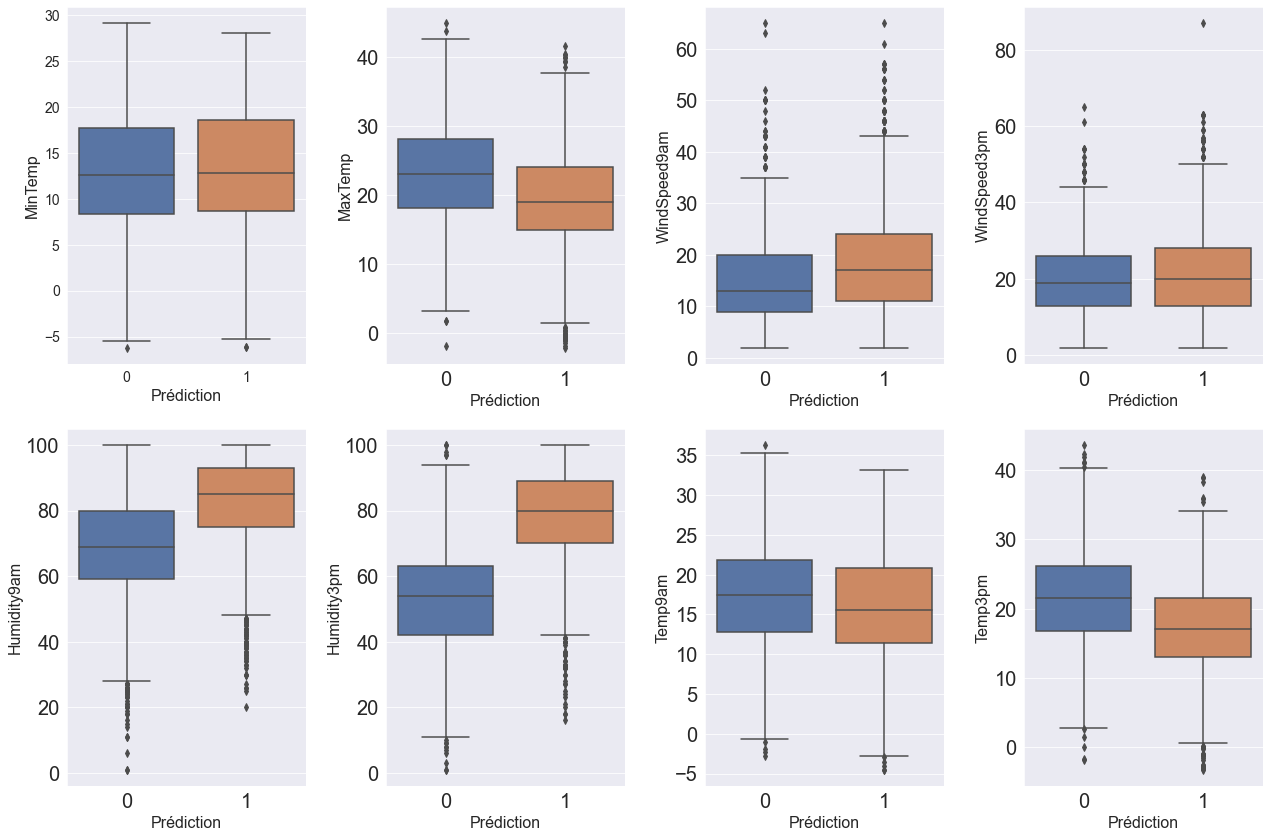

Dans ces graphes, on considère tous les jours réels de pluie. Les box bleues correspondent à 
de fausses prédictions (FN) tandis que les oranges sont de bonnes prédictions (VP).
Par rapport aux mauvaises prédictions, les bonnes prédictions sont issues de valeurs moins élevées pour les variables 
de fortes températures (<i>MaxTemp</i> et <i>Temp3pm</i>) et des valeurs plus élevées pour les variables liées à 
l’humidité et à la direction du vent le matin (<i>WindSpeed9am</i>). Nous pouvons également remarquer que ces variables 
présentent beaucoup de valeurs extrêmes.


In [4]:
display(Markdown("<h2><u><center>Modélisation Random Forest</center></u></h2>"))
display(Markdown("<h4><u>Performances du modèle :</u></h4>"))

rf1 = RandomForestClassifier()

rf1.fit(X_res, y_res)
y_pred1 = rf1.predict(X_test)

display(Markdown("<h5><i>Matrice de confusion :</i></h5>"))
print(pd.crosstab(y_test, y_pred1, rownames = ['Classe réelle'], colnames = ['Classe prédite']))

display(Markdown("<h5><i>Rapport de classification :</i></h5>"))
print(metrics.classification_report(y_test, y_pred1))

display(Markdown("""Le modèle appliqué sur données ré-équilibrées par Over puis Undersampling montre 
un <i>f1_score</i> (<b>{}</b>) acceptable, la classe “jour de pluie” est correctement détectée par le modèle. 
L’<i>accuracy</i> est de <b>{} %</b>, notre modèle semble fiable pour la détection correcte des classes 
(vrais négatifs et vrais positifs). 
""".format(round(metrics.classification_report(y_test, y_pred1,output_dict=True)["1"]["f1-score"],2), 
           round(metrics.classification_report(y_test, y_pred1,output_dict=True)["accuracy"],2))))

display(Markdown("<h4><u>Analyse feature importance :</u></h4>"))
importances = rf1.feature_importances_
impor=pd.DataFrame(data=(importances), index=data.columns, columns=['Importance'])
impor=impor.sort_values(by='Importance', ascending=False)

display(Markdown("""Les variables qui semblent le plus influer sur la prédiction sont les variables 
liées à l’humidité et à la température, toutefois les faibles scores appellent à la prudence pour leur interprétation.
"""))
print(impor.head(15).round(3))

display(Markdown("<h4><u>Analyse des faux positifs et faux négatifs :</u></h4>"))

predictions = pd.DataFrame(y_pred1).set_index(y_test.index)
predictions.columns = ['predictions']
df_rain = [y_test, predictions]
df_compare = X_test.join(other = df_rain).reset_index()
df_compare.drop('index', axis = 1,  inplace = True)

# création des sous-df:
VN = df_compare[(df_compare['RainTomorrow'] == 0) & (df_compare['predictions'] == 0)]
VP = df_compare[(df_compare['RainTomorrow'] == 1) & (df_compare['predictions'] == 1)] #intéressant à analyser
FP = df_compare[(df_compare['RainTomorrow'] == 0) & (df_compare['predictions'] == 1)] #intéressant à analyser
FN = df_compare[(df_compare['RainTomorrow'] == 1) & (df_compare['predictions'] == 0)]

FN_VP = pd.concat([FN, VP], axis = 0)

plt.figure(figsize=(18, 12))

plt.subplot(241)
sns.boxplot(data=FN_VP, x='predictions', y='MinTemp')
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.xlabel("Prédiction", fontsize = 16)
plt.ylabel("MinTemp", fontsize = 16)

plt.subplot(242)
sns.boxplot(data=FN_VP, x='predictions', y='MaxTemp')
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel("Prédiction", fontsize = 16)
plt.ylabel("MaxTemp", fontsize = 16)

plt.subplot(243)
sns.boxplot(data=FN_VP, x='predictions', y='WindSpeed9am')
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel("Prédiction", fontsize = 16)
plt.ylabel("WindSpeed9am", fontsize = 16)

plt.subplot(244)
sns.boxplot(data=FN_VP, x='predictions', y='WindSpeed3pm')
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel("Prédiction", fontsize = 16)
plt.ylabel("WindSpeed3pm", fontsize = 16)

plt.subplot(245)
sns.boxplot(data=FN_VP, x='predictions', y='Humidity9am')
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel("Prédiction", fontsize = 16)
plt.ylabel("Humidity9am", fontsize = 16)

plt.subplot(246)
sns.boxplot(data=FN_VP, x='predictions', y='Humidity3pm')
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel("Prédiction", fontsize = 16)
plt.ylabel("Humidity3pm", fontsize = 16)

plt.subplot(247)
sns.boxplot(data=FN_VP, x='predictions', y='Temp9am')
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel("Prédiction", fontsize = 16)
plt.ylabel("Temp9am", fontsize = 16)

plt.subplot(248)
sns.boxplot(data=FN_VP, x='predictions', y='Temp3pm');
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel("Prédiction", fontsize = 16)
plt.ylabel("Temp3pm", fontsize = 16)

plt.tight_layout(pad=2)
plt.show();

display(Markdown("""Dans ces graphes, on considère tous les jours réels de pluie. Les box bleues correspondent à 
de fausses prédictions (FN) tandis que les oranges sont de bonnes prédictions (VP).
Par rapport aux mauvaises prédictions, les bonnes prédictions sont issues de valeurs moins élevées pour les variables 
de fortes températures (<i>MaxTemp</i> et <i>Temp3pm</i>) et des valeurs plus élevées pour les variables liées à 
l’humidité et à la direction du vent le matin (<i>WindSpeed9am</i>). Nous pouvons également remarquer que ces variables 
présentent beaucoup de valeurs extrêmes.
"""))


In [5]:
display(Markdown("<h2><u><center>Essai d'amélioration du modèle</center></u></h2>"))
display(Markdown("<h4><u>Concept :</u></h4>"))

display(Markdown("""Nous avons formulé l’hypothèse que la suppression de 8 variables pouvait limiter les performances 
du modèle, considérant que lesdites variables pouvaient influencer significativement la prédiction. Vu l’étendue du 
territoire australien et la diversité des climats présents, nous avions fait le choix de remplacer les valeurs manquantes 
station par station. Toutefois l’absence de valeurs sur des mois entiers empêchant de procéder à un tel remplacement, 
nous avons opté secondairement pour un rapprochement géographique. Sur les 49 stations, 6 n’étaient pas éligibles à un 
tel rapprochement avec au moins une autre station. Des 43 stations éligibles, nous avons procédé à un regroupement en 
15 groupes distincts, en suivant la concordance géographique selon une carte répertoriée sur le même site que les données.
"""))

display(Markdown("<h4><u>Préprocessing révisé :</u></h4>"))

df = pd.read_csv("weatherAUS.csv")

#Création de Year, Month & Day
df["Year"] = df["Date"].apply(lambda x : int(x[:4]))
df["Month"] = df["Date"].apply(lambda x : int(x[5:7]))
df["Day"] = df["Date"].apply(lambda x : int(x[8:]))

#Création du dictionnaire qui contient pour chaque état australier, les stations associées
localites = {"SA" : ["Adelaide", "MountGambier", "Woomera", "Nuriootpa"],
            "WA" : ["Perth", "Albany", "PearceRAAF", "PerthAirport", "Walpole", "SalmonGums", "Witchcliffe"],
            "NSW" : ["Canberra", "Sydney", "Albury", "Wollongong", "MountGinini", "Tuggeranong", "Penrith", "Newcastle", "Cobar", "SydneyAirport", "BadgerysCreek", "WaggaWagga", "Moree", "Williamtown", "CoffsHarbour", "NorahHead", "Richmond"],
            "QLD" : ["Brisbane", "Townsville", "Cairns", "GoldCoast"],
            "TAS" : ["Hobart", "Launceston"],
            "VIC" : ["Melbourne", "Bendigo", "Ballarat", "Dartmoor", "Portland", "Mildura", "MelbourneAirport", "Sale", "Watsonia", "Nhil"],
            "NT" : ["Darwin", "AliceSprings", "Katherine", "Uluru"],
            "NI" : ["NorfolkIsland"]}

#Création de la colonne State
df["State"] = df.Location
df["State"] = df["State"].replace(to_replace = ["Adelaide", "MountGambier", "Woomera", "Nuriootpa"], value = "SA")
df["State"] = df["State"].replace(to_replace = ["Perth", "Albany", "PearceRAAF", "PerthAirport", "Walpole", "SalmonGums", "Witchcliffe"], value = "WA")
df["State"] = df["State"].replace(to_replace = ["Canberra", "Sydney", "Albury", "Wollongong", "MountGinini", "Tuggeranong", "Penrith", "Newcastle", "Cobar", "SydneyAirport", "BadgerysCreek", "WaggaWagga", "Moree", "Williamtown", "CoffsHarbour", "NorahHead", "Richmond"], value = "NSW")
df["State"] = df["State"].replace(to_replace = ["Brisbane", "Townsville", "Cairns", "GoldCoast"], value = "QLD")
df["State"] = df["State"].replace(to_replace = ["Hobart", "Launceston"], value = "TAS")
df["State"] = df["State"].replace(to_replace = ["Melbourne", "Bendigo", "Ballarat", "Dartmoor", "Portland", "Mildura", "MelbourneAirport", "Sale", "Watsonia", "Nhil"], value = "VIC")
df["State"] = df["State"].replace(to_replace = ["Darwin", "AliceSprings", "Katherine", "Uluru"], value = "NT")
df["State"] = df["State"].replace(to_replace = ["NorfolkIsland"], value = "NI")

#Création des deux listes nécessaires au remplacement des nans.
loclst = []
locgroup = ["NorfolkIsland", "Portland", "MountGinini", "Adelaide", "Darwin", "MountGambier", "GoldCoast", "Canberra", "Newcastle", "Woomera",
           "Witchcliffe", "Moree", "Wollongong", "Bendigo", "Mildura", "WaggaWagga", "Dartmoor","Hobart", "SalmonGums", "Williamtown",
            "Townsville", "PerthAirport", "Sydney", "Perth", "Katherine", "Albury", "Ballarat", "MelbourneAirport",
           "BagerysCreek", "Melbourne", "Cairns", "NorahHead", "PearceRAAF", "Uluru", "Nhil", "Sale", "Richmond", 
            "Cobar", "Penrith", "CoffsHarbour", "Nuriootpa", "Albany", "SydneyAirport", "Tuggeranong",
            "Lauceston", "Brisbane", "Watsonia", "Walpole", "AliceSprings"]

#Boucle de remplacement géographique des nans
for loc in locgroup:
    loclst.append(df[df["Location"] == loc])

df_NorfolkIsland = loclst[0]  
df_Portland = loclst[1]
df_MountGinini = loclst[2]   
df_Adelaide = loclst[3]
df_Darwin = loclst[4]
df_MountGambier = loclst[5]
df_GoldCoast = loclst[6]
df_Canberra = loclst[7]
df_Newcastle = loclst[8]
df_Woomera = loclst[9]
df_Witchcliffe = loclst[10]
df_Moree = loclst[11]
df_Wollongong = loclst[12]
df_Bendigo = loclst[13]
df_Mildura = loclst[14]
df_WaggaWagga = loclst[15]
df_Dartmoor = loclst[16]
df_Hobart = loclst[17]
df_SalmonGums = loclst[18]
df_Williamtown = loclst[19]
df_Townsville = loclst[20]
df_PerthAirport = loclst[21]
df_Sydney = loclst[22]
df_Perth = loclst[23]
df_Katherine = loclst[24]
df_Albury = loclst[25]
df_Ballarat = loclst[26]
df_MelbourneAirport = loclst[27]
df_BadgerysCreek = loclst[28]
df_Melbourne = loclst[29]
df_Cairns = loclst[30]
df_NorahHead = loclst[31]
df_PearceRAAF = loclst[32]
df_Uluru = loclst[33]
df_Nhil = loclst[34]
df_Sale = loclst[35]
df_Richmond = loclst[36]
df_Cobar = loclst[37]
df_Penrith = loclst[38]
df_CoffsHarbour = loclst[39]
df_Nuriootpa = loclst[40]
df_Albany = loclst[41]
df_SydneyAirport = loclst[42]
df_Tuggeranong = loclst[43]
df_Lauceston = loclst[44]
df_Brisbane = loclst[45]
df_Watsonia = loclst[46]
df_Walpole = loclst[47]
df_AliceSprings = loclst[48]

#Dictionnaire permettant le rappel des regroupements géographiques
geogroup = {"df_Perth2" : "Perth, PerthAirport, PearceRAAF",
           "df_Albany2" : "Albany, Witchcliffe, Walpole",
           "df_Alice2" : "AliceSprings, Uluru",
           "df_Adelaide2" : "Adelaide, Nuriootpa",
           "df_Nhil2" : "Nhil, Mildura, Bendigo",
           "df_Portland2" : "Portland, Dartmoor, MountGambier",
           "df_Melbourne2" : "Melbourne, MelbourneAirport, Ballarat, Watsonia, Sale",
           "df_Albury2" : "Albury, WaggaWagga",
           "df_Canberra2" : "Canberra, Tugganong",
           "df_Sydney2" : "Sydney, SydneyAirport, Richmond, Penrith, BadgeryCreeks, Wollongong",
           "df_Newcastle2" : "Newcastle, NorahHead, Williamtown",
           "df_Cobar2" : "Cobar, Moree",
           "df_Brisbane2" : "Brisbane, GoldCoast, CoffsHarbour",
           "df_Cairns2" : "Townsville, Cairns",
           "df_Hobart2" : "Hobart, Launceston",
           "non_poolés" : "SalmonGums, Darwin, Katherine, Woomera, MountGinini, NorfolkIsland"}

#Création des dataframes pour remplacement des nans par regroupement géographique
df_Perth2 = pd.concat([df_Perth, df_PerthAirport, df_PearceRAAF])
df_Albany2 = pd.concat([df_Albany, df_Witchcliffe, df_Walpole])
df_Alice2 = pd.concat([df_AliceSprings, df_Uluru])
df_Adelaide2 = pd.concat([df_Adelaide, df_Nuriootpa])
df_Nhil2 = pd.concat([df_Nhil, df_Mildura, df_Bendigo])
df_Portland2 = pd.concat([df_Portland, df_Dartmoor, df_MountGambier])
df_Melbourne2 = pd.concat([df_Melbourne, df_MelbourneAirport, df_Ballarat, df_Watsonia, df_Sale])
df_Albury2 = pd.concat([df_Albury, df_WaggaWagga])
df_Canberra2 = pd.concat([df_Canberra, df_Tuggeranong])
df_Sydney2 = pd.concat([df_Sydney, df_SydneyAirport, df_Richmond, df_Penrith, df_BadgerysCreek, df_Wollongong])
df_Newcastle2 = pd.concat([df_Newcastle, df_NorahHead, df_Williamtown])
df_Cobar2 = pd.concat([df_Cobar, df_Moree])
df_Brisbane2 = pd.concat([df_Brisbane, df_GoldCoast, df_CoffsHarbour])
df_Cairns2 = pd.concat([df_Townsville, df_Cairns])
df_Hobart2 = pd.concat([df_Hobart, df_Lauceston])

geolist_brute = [df_Perth2, df_Albany2, df_Alice2, df_Adelaide2, df_Nhil2, df_Portland2, df_Melbourne2,
df_Albury2, df_Canberra2, df_Sydney2, df_Newcastle2, df_Cobar2, df_Brisbane2, df_Cairns2, df_Hobart2,
           df_SalmonGums, df_Darwin, df_Katherine, df_Woomera, df_MountGinini, df_NorfolkIsland]

geolist_str = ["df_Perth2", "df_Albany2", "df_Alice2", "df_Adelaide2", "df_Nhil2", "df_Portland2", "df_Melbourne2",
"df_Albury2", "df_Canberra2", "df_Sydney2", "df_Newcastle2", "df_Cobar2", "df_Brisbane2", "df_Cairns2", "df_Hobart2",
           "df_SalmonGums", "df_Darwin", "df_Katherine", "df_Woomera", "df_MountGinini", "df_NorfolkIsland"]
#Remplacement des nans et régénération des df groupés

geolist_clean = []
k = 0

for df in geolist_brute:
    df_temp = df
    print("In progress: {}. {} nans before cleaning ({} %)".format(geolist_str[k], geolist_brute[k].isna().sum().sum(), round(100*(geolist_brute[k].isna().sum().sum())/(geolist_brute[k].shape[0]*geolist_brute[k].shape[1]),1)))

    #Elimination des nans sur RainToday et RainTomorrow
    df_temp.dropna(axis = 0, how = "any", inplace = True, subset = ["RainToday", "RainTomorrow"])

    for i in range(1,13,1):
                  
        #Remplacement des nans de MinTemp
        df_temp.MinTemp[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")] = df_temp.MinTemp[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].fillna(df_temp.MinTemp[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].mean())
        df_temp.MinTemp[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")] = df_temp.MinTemp[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].fillna(df_temp.MinTemp[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].mean())
            
        #Remplacement des nans de MaxTemp
        df_temp.MaxTemp[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")] = df_temp.MaxTemp[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].fillna(df_temp.MaxTemp[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].mean())
        df_temp.MaxTemp[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")] = df_temp.MaxTemp[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].fillna(df_temp.MaxTemp[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].mean())
        
        #Remplacement de Rainfall
        df_temp.Rainfall[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")] = df_temp.Rainfall[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].fillna(df_temp.Rainfall[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].median())
        df_temp.Rainfall[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")] = df_temp.Rainfall[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].fillna(df_temp.Rainfall[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].median())
                
        #Evaporation :
        df_temp.Evaporation[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")] = df_temp.Evaporation[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].fillna(df_temp.Evaporation[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].median())
        df_temp.Evaporation[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")] = df_temp.Evaporation[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].fillna(df_temp.Evaporation[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].median())
        
        #Sunshine :
        df_temp.Sunshine[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")] = df_temp.Sunshine[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].fillna(df_temp.Sunshine[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].median())
        df_temp.Sunshine[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")] = df_temp.Sunshine[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].fillna(df_temp.Sunshine[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].median())
        
        #WindGustdir :
        df_temp.WindGustDir[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")] = df_temp.WindGustDir[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].fillna(df_temp.WindGustDir[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].mode())
        df_temp.WindGustDir[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")] = df_temp.WindGustDir[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].fillna(df_temp.WindGustDir[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].mode())
        
        #WindGustSpeed :
        df_temp.WindGustSpeed[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")] = df_temp.WindGustSpeed[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].fillna(df_temp.WindGustSpeed[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].mean())
        df_temp.WindGustSpeed[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")] = df_temp.WindGustSpeed[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].fillna(df_temp.WindGustSpeed[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].mean())
                
        #WindDir9am :
        df_temp.WindGustDir[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")] = df_temp.WindGustDir[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].fillna(df_temp.WindGustDir[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].mode([0]))
        df_temp.WindGustDir[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")] = df_temp.WindGustDir[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].fillna(df_temp.WindGustDir[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].mode([0]))
                
        #WindDir3pm :
        df_temp.WindGustDir[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")] = df_temp.WindGustDir[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].fillna(df_temp.WindGustDir[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].mode([0]))
        df_temp.WindGustDir[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")] = df_temp.WindGustDir[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].fillna(df_temp.WindGustDir[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].mode([0]))
        
        #WindSpeed9am :
        df_temp.WindSpeed9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")] = df_temp.WindSpeed9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].fillna(df_temp.WindSpeed9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].mean())
        df_temp.WindSpeed9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")] = df_temp.WindSpeed9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].fillna(df_temp.WindSpeed9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].mean())
        
        #WindSpeed3pm :
        df_temp.WindSpeed3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")] = df_temp.WindSpeed3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].fillna(df_temp.WindSpeed3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].mean())
        df_temp.WindSpeed3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")] = df_temp.WindSpeed3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].fillna(df_temp.WindSpeed3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].mean())
           
        #Humidity9am
        df_temp.Humidity9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")] = df_temp.Humidity9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].fillna(df_temp.Humidity9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].mean())
        df_temp.Humidity9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")] = df_temp.Humidity9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].fillna(df_temp.Humidity9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].mean())
            
        #Humidity3pm
        df_temp.Humidity3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")] = df_temp.Humidity3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].fillna(df_temp.Humidity3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].mean())
        df_temp.Humidity3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")] = df_temp.Humidity3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].fillna(df_temp.Humidity3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].mean())

        #Pressure9am
        df_temp.Pressure9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")] = df_temp.Pressure9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].fillna(df_temp.Pressure9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].mean())
        df_temp.Pressure9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")] = df_temp.Pressure9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].fillna(df_temp.Pressure9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].mean())

        #Pressure9am
        df_temp.Pressure3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")] = df_temp.Pressure3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].fillna(df_temp.Pressure3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].mean())
        df_temp.Pressure3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")] = df_temp.Pressure3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].fillna(df_temp.Pressure3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].mean())

        #Cloud9am
        df_temp.Cloud9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")] = df_temp.Cloud9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].fillna(df_temp.Cloud9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].mean())
        df_temp.Cloud9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")] = df_temp.Cloud9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].fillna(df_temp.Cloud9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].mean())

        #Cloud3pm
        df_temp.Cloud3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")] = df_temp.Cloud3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].fillna(df_temp.Cloud3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].mean())
        df_temp.Cloud3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")] = df_temp.Cloud3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].fillna(df_temp.Cloud3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].mean())

        #Temp9am
        df_temp.Temp9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")] = df_temp.Temp9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].fillna(df_temp.Temp9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].mean())
        df_temp.Temp9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")] = df_temp.Temp9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].fillna(df_temp.Temp9am[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].mean())
            
        #Temp3pm
        df_temp.Temp3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")] = df_temp.Temp3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].fillna(df_temp.Temp3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "Yes")].mean())
        df_temp.Temp3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")] = df_temp.Temp3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].fillna(df_temp.Temp3pm[(df_temp["Month"] == i) & (df_temp["RainToday"] == "No")].mean())
        
    geolist_clean.append(df_temp)
    print("\tCleaning done: {}. {} nans remaining ({} %)".format(geolist_str[k], df_temp.isna().sum().sum(), round(100*(df_temp.isna().sum().sum())/(df_temp.shape[0]*df_temp.shape[1]),1)))
    print("\n---------------------------------------------------------------")
    k+=1
    
print("Cleaning complete.")

df_Perth2 = geolist_clean[0]
df_Albany2 = geolist_clean[1]
df_Alice2 = geolist_clean[2]
df_Adelaide2 = geolist_clean[3]
df_Nhil2 = geolist_clean[4]
df_Portland2 = geolist_clean[5]
df_Melbourne2 = geolist_clean[6]
df_Albury2 = geolist_clean[7]
df_Canberra2 = geolist_clean[8]
df_Sydney2 = geolist_clean[9]
df_Newcastle2 = geolist_clean[10]
df_Cobar2 = geolist_clean[11]
df_Brisbane2 = geolist_clean[12]
df_Cairns2 = geolist_clean[13]
df_Hobart2 = geolist_clean[14]
df_SalmonGums = geolist_clean[15]
df_Darwin = geolist_clean[16]
df_Katherine = geolist_clean[17]
df_Woomera = geolist_clean[18]
df_MountGinini = geolist_clean[19]
df_NorfolkIsland = geolist_clean[20]

#Reconstitution du df global

data_full = pd.concat(geolist_clean)

#Suppression des variables avec trop de nans

data = data_full.drop(["Sunshine", "WindGustDir", "WindDir9am", "WindDir3pm"], axis = 1)

#Supression des nans restant
data = data.dropna()

display(Markdown("""Il y avait initialement <b>{} valeurs manquantes</b> dans la base de données (<b>{} %</b> des données totales), répartis sur {} entrées.
Le preprocessing a permis de réduire le nombre de valeurs manquantes à <b>{}</b> : <b>{} %</b> des valeurs manquantes initiales ont été remplacés.
Après suppression de 4 colonnes comportant trop de valeurs manquantes, et suppression des valeurs manquantes restantes, il reste <b>{} relevés</b> dans la base.
Au total, <b>{} %</b> des relevés météorologiques ont été <b>conservés</b>.
""".format(
    df_saved.isna().sum().sum(),
    round(100*df_saved.isna().sum().sum()/(df_saved.shape[0]*df_saved.shape[1]),1),
    df_saved.shape[0],
    data_full.isna().sum().sum(),
    100-round(100*data_full.isna().sum().sum()/df_saved.isna().sum().sum(), 1),
    data.shape[0],
    round(100*data.shape[0]/df_saved.shape[0],1)
)))


#WindSpeedDiff, HumidityDiff, TempDiff
data["WindSpeedDiff"] = data["WindSpeed3pm"] - data["WindSpeed9am"]
data["HumidityDiff"] = data["Humidity3pm"] - data["Humidity9am"]
data["TempDiff"] = data["Temp3pm"] - data["Temp9am"]

#MinMaxDiff
data["MinMaxDiff"] = data["MaxTemp"] - data["MinTemp"]

#PressureDiff
data["PressureDiff"] = data["Pressure3pm"] - data["Pressure9am"]

#CloudDiff
data["CloudDiff"] = data["Cloud3pm"] - data["Cloud9am"]

#Encodage de RainToday et RainTomorrow
encoder = preprocessing.LabelEncoder()
LE_cols = ["RainToday", "RainTomorrow"]
for col in LE_cols:
    data[col] = encoder.fit_transform(data[col])
    
feats = data.drop(["RainTomorrow", "Date", "Year", "Month", "Day", "State", "Location"], axis = 1)
target = data["RainTomorrow"]

# On sépare les données en un ensemble d'apprentissage et un ensemble de test, avec le ratio 80/20
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size = 0.2, random_state = 55)

rf1 = RandomForestClassifier()

over = RandomOverSampler(sampling_strategy = 0.6) # Fraction 60/40 
under = RandomUnderSampler() 

X_ov, y_ov = over.fit_resample(X_train, y_train) 
X_res, y_res = under.fit_resample(X_ov, y_ov) 

rf1.fit(X_res, y_res)
y_pred1 = rf1.predict(X_test)

print(pd.crosstab(y_test, y_pred1, rownames = ['Classe réelle'], colnames = ['Classe prédite']))

precis = metrics.classification_report(y_test, y_pred1, output_dict=True)

display(Markdown("""<h4><u>Performances du modèle</u></h4>
<h5>Récapitulatif du modèle :</h5>
<ul><li>Modèle <b>random forest</b>.</li>
<li> préprocessing = <b>oversampling</b> puis <b>undersampling</b>.</li></ul>
<h5>Résultats du modèle :</h5>
<ul><li> Prédiction des <b>jours de pluie</b> avec une précision de <b>{} %</b> (<i>recall = <b>{} %</b>, f1-score = <b>{} %</b></i>)</li>
<li> Prédiction des <b>jours sans pluie</b> avec une précision de <b>{} %</b> (<i>recall = <b>{} %</b>, f1-score = <b>{} %</b></i>)</li>.
<li>La précision globale du modèle est de <b>{} %</b>.</li></ul>
Les paramètres de ce premier modèle ont été fixés de façon plus ou moins arbritraire. Les 
performances de ce modèle sont globalement satisfaisantes, voire très satisfaisantes pour la détection des jours sans pluie.
Il serait toutefois intéressant d'améliorer la prédiction de jours de pluie.
""".format(
    round(100*precis["1"]["precision"],2),
    round(100*precis["1"]["recall"],2),
    round(100*precis["1"]["f1-score"],2),
    round(100*precis["0"]["precision"],2),
    round(100*precis["0"]["recall"],2),
    round(100*precis["0"]["f1-score"],2),
    round(100*precis["accuracy"],2)
)))

display(Markdown("<h5><i>Rapport de classification</i></h5>"))
print(metrics.classification_report(y_test, y_pred1))

<h2><u><center>Essai d'amélioration du modèle</center></u></h2>

<h4><u>Concept :</u></h4>

Nous avons formulé l’hypothèse que la suppression de 8 variables pouvait limiter les performances 
du modèle, considérant que lesdites variables pouvaient influencer significativement la prédiction. Vu l’étendue du 
territoire australien et la diversité des climats présents, nous avions fait le choix de remplacer les valeurs manquantes 
station par station. Toutefois l’absence de valeurs sur des mois entiers empêchant de procéder à un tel remplacement, 
nous avons opté secondairement pour un rapprochement géographique. Sur les 49 stations, 6 n’étaient pas éligibles à un 
tel rapprochement avec au moins une autre station. Des 43 stations éligibles, nous avons procédé à un regroupement en 
15 groupes distincts, en suivant la concordance géographique selon une carte répertoriée sur le même site que les données.


<h4><u>Préprocessing révisé :</u></h4>

In progress: df_Perth2. 6901 nans before cleaning (2.8 %)
	Cleaning done: df_Perth2. 432 nans remaining (0.2 %)

---------------------------------------------------------------
In progress: df_Albany2. 38056 nans before cleaning (15.6 %)
	Cleaning done: df_Albany2. 4583 nans remaining (2.0 %)

---------------------------------------------------------------
In progress: df_Alice2. 7895 nans before cleaning (6.3 %)
	Cleaning done: df_Alice2. 381 nans remaining (0.3 %)

---------------------------------------------------------------
In progress: df_Adelaide2. 11572 nans before cleaning (6.9 %)
	Cleaning done: df_Adelaide2. 498 nans remaining (0.3 %)

---------------------------------------------------------------
In progress: df_Nhil2. 14159 nans before cleaning (6.9 %)
	Cleaning done: df_Nhil2. 473 nans remaining (0.2 %)

---------------------------------------------------------------
In progress: df_Portland2. 12342 nans before cleaning (5.0 %)
	Cleaning done: df_Portland2. 780 nans rem

Il y avait initialement <b>343248 valeurs manquantes</b> dans la base de données (<b>10.3 %</b> des données totales), répartis sur 145460 entrées.
Le preprocessing a permis de réduire le nombre de valeurs manquantes à <b>57622</b> : <b>83.2 %</b> des valeurs manquantes initiales ont été remplacés.
Après suppression de 4 colonnes comportant trop de valeurs manquantes, et suppression des valeurs manquantes restantes, il reste <b>129127 relevés</b> dans la base.
Au total, <b>88.8 %</b> des relevés météorologiques ont été <b>conservés</b>.


Classe prédite      0     1
Classe réelle              
0               17971  2279
1                1764  3812


<h4><u>Performances du modèle</u></h4>
<h5>Récapitulatif du modèle :</h5>
<ul><li>Modèle <b>random forest</b>.</li>
<li> préprocessing = <b>oversampling</b> puis <b>undersampling</b>.</li></ul>
<h5>Résultats du modèle :</h5>
<ul><li> Prédiction des <b>jours de pluie</b> avec une précision de <b>62.58 %</b> (<i>recall = <b>68.36 %</b>, f1-score = <b>65.35 %</b></i>)</li>
<li> Prédiction des <b>jours sans pluie</b> avec une précision de <b>91.06 %</b> (<i>recall = <b>88.75 %</b>, f1-score = <b>89.89 %</b></i>)</li>.
<li>La précision globale du modèle est de <b>84.35 %</b>.</li></ul>
Les paramètres de ce premier modèle ont été fixés de façon plus ou moins arbritraire. Les 
performances de ce modèle sont globalement satisfaisantes, voire très satisfaisantes pour la détection des jours sans pluie.
Il serait toutefois intéressant d'améliorer la prédiction de jours de pluie.


<h5><i>Rapport de classification</i></h5>

              precision    recall  f1-score   support

           0       0.91      0.89      0.90     20250
           1       0.63      0.68      0.65      5576

    accuracy                           0.84     25826
   macro avg       0.77      0.79      0.78     25826
weighted avg       0.85      0.84      0.85     25826

